<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/cat_skeleton_detection_three_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
tf.__version__
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


In [3]:
!pip show pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' &> /dev/null

Name: PyYAML
Version: 6.0
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: albumentations, bokeh, dask, distributed, fastai, PyDrive


In [6]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [7]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("cat_keypoints_train", {}, "/content/drive/MyDrive/Dataset/cats/annotations/person_keypoints_default.json", "/content/drive/MyDrive/Dataset/cats/images")

In [8]:
#MetadataCatalog.remove("person_keypoints_train")
#DatasetCatalog.remove("person_keypoints_train")

In [9]:
keypoint_names = ['nose', 'left_eye', 'right_eye']
keypoint_flip_map = [('left_eye', 'right_eye')]
keypoint_connection_rules = [('left_eye', 'left_eye', (102, 204, 255)),('nose', 'left_eye', (102, 204, 255)),('nose', 'right_eye', (102, 204, 255))]
MetadataCatalog.remove("cat_keypoints_train")

In [10]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("cat_keypoints_train").keypoint_connection_rules = keypoint_connection_rules
MetadataCatalog.get("cat_keypoints_train").thing_classes = ["threepoints"]
MetadataCatalog.get("cat_keypoints_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("cat_keypoints_train").keypoint_names = keypoint_names
MetadataCatalog.get("cat_keypoints_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("cat_keypoints_train").evaluator_type="coco"

In [11]:
cat_metadata = MetadataCatalog.get("cat_keypoints_train")
cat_metadata

Metadata(evaluator_type='coco', keypoint_connection_rules=[('left_eye', 'left_eye', (102, 204, 255)), ('nose', 'left_eye', (102, 204, 255)), ('nose', 'right_eye', (102, 204, 255))], keypoint_flip_map=[('left_eye', 'right_eye')], keypoint_names=['nose', 'left_eye', 'right_eye'], name='cat_keypoints_train', thing_classes=['threepoints'], thing_dataset_id_to_contiguous_id={1: 0})

In [12]:
dataset_dicts = DatasetCatalog.get("cat_keypoints_train")
dataset_dicts[0]

[03/01 16:08:33 d2.data.datasets.coco]: Loaded 309 images in COCO format from /content/drive/MyDrive/Dataset/cats/annotations/person_keypoints_default.json


{'file_name': '/content/drive/MyDrive/Dataset/cats/images/00000001_000.jpg',
 'height': 500,
 'width': 375,
 'image_id': 1,
 'annotations': [{'iscrowd': 0,
   'bbox': [177.27, 162.65, 63.58, 30.47],
   'keypoints': [200.16, 193.62, 2, 177.77, 163.15, 2, 241.35, 166.15, 2],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

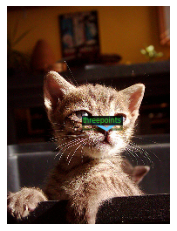

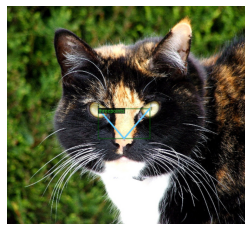

In [13]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

cat_metadata = MetadataCatalog.get("cat_keypoints_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=cat_metadata, scale=0.5)    
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [14]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml"))
cfg.DATASETS.TRAIN = ("cat_keypoints_train",)


#cfg.DATASETS.TEST = ("hand_test",)  #Dataset 'hand_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_train.pth")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 8000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # person
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((3, 1), dtype=float).tolist()


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/01 16:08:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Trigg

[03/01 16:09:05 d2.utils.events]:  eta: 0:58:39  iter: 19  total_loss: 211  loss_cls: 2.781  loss_box_reg: 0.3624  loss_keypoint: 186.9  loss_rpn_cls: 0.6719  loss_rpn_loc: 1.667  time: 0.4386  last_time: 0.4486  data_time: 0.0337  last_data_time: 0.0137   lr: 4.9953e-06  max_mem: 2740M
[03/01 16:09:15 d2.utils.events]:  eta: 0:59:42  iter: 39  total_loss: 16.95  loss_cls: 0.5044  loss_box_reg: 0.02423  loss_keypoint: 16.05  loss_rpn_cls: 0.3219  loss_rpn_loc: 0.2111  time: 0.4664  last_time: 1.3096  data_time: 0.0545  last_data_time: 0.8415   lr: 9.9902e-06  max_mem: 2740M
[03/01 16:09:24 d2.utils.events]:  eta: 0:59:33  iter: 59  total_loss: 6.995  loss_cls: 0.2843  loss_box_reg: 0.00363  loss_keypoint: 5.935  loss_rpn_cls: 0.171  loss_rpn_loc: 0.1103  time: 0.4600  last_time: 0.4703  data_time: 0.0125  last_data_time: 0.0075   lr: 1.4985e-05  max_mem: 2740M
[03/01 16:09:33 d2.utils.events]:  eta: 0:59:52  iter: 79  total_loss: 4.863  loss_cls: 0.2006  loss_box_reg: 0.00215  loss_key

In [15]:
del cfg

In [16]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3

predictor = DefaultPredictor(cfg)

[03/01 17:15:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [17]:
im = cv2.imread("/content/drive/MyDrive/Dataset/cats/images/00000001_000.jpg")
outputs = predictor(im)
print(outputs["instances"])

Instances(num_instances=1, image_height=500, image_width=375, fields=[pred_boxes: Boxes(tensor([[178.8287, 165.6234, 233.4579, 191.9555]], device='cuda:0')), scores: tensor([0.9820], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_keypoints: tensor([[[2.0054e+02, 1.9034e+02, 9.5461e-02],
         [1.7906e+02, 1.6585e+02, 4.8284e-01],
         [2.3322e+02, 1.6585e+02, 9.2524e-02]]], device='cuda:0'), pred_keypoint_heatmaps: tensor([[[[-3.3263, -3.6243, -4.2203,  ..., -2.9938, -2.0923, -1.6416],
          [-3.0868, -3.4759, -4.2541,  ..., -3.1182, -2.1157, -1.6144],
          [-2.6076, -3.1790, -4.3218,  ..., -3.3670, -2.1624, -1.5601],
          ...,
          [-1.1670, -1.3462, -1.7047,  ..., -2.3998, -1.7849, -1.4774],
          [-0.3431, -0.7283, -1.4988,  ..., -1.8680, -0.7779, -0.2328],
          [ 0.0688, -0.4194, -1.3959,  ..., -1.6021, -0.2744,  0.3894]],

         [[ 9.1592,  7.3300,  3.6716,  ..., -2.4284, -2.1210, -1.9673],
          [ 8.6514,  7.0467,  3.8

In [18]:
list(outputs['instances'].pred_classes)

[tensor(0, device='cuda:0')]

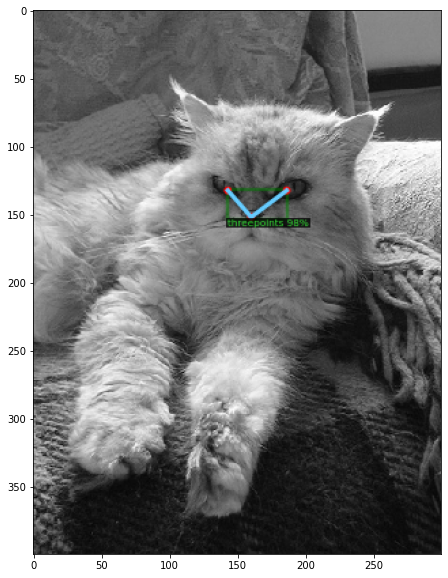

In [19]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1],
  metadata=cat_metadata, 
  scale=0.8, 
  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)


v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()


# o = outputs["instances"]
# #Create new class, boxes, scores & masks
# classes = o.pred_classes[idxofClass]
# scores = o.scores[idxofClass]
# boxes = o.pred_boxes[idxofClass]
# #masks = o.pred_masks[idxofClass]

# #Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
# obj = detectron2.structures.Instances(image_size=(480, 640))

# obj.set('pred_classes', classes)
# obj.set('scores', scores)
# obj.set('pred_boxes', boxes)

# obj